## Лабораторная работа №5
    ФИО: Михайлов Александр Евгеньевич
    Группа: БИВТ-23-СП-1

### 1. Загрузить данные

In [2]:
import kagglehub
path = kagglehub.dataset_download("mahmoudreda55/satellite-image-classification")

Using Colab cache for faster access to the 'satellite-image-classification' dataset.


In [3]:
import torch
import kagglehub
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Путь к датасету
data_path = data_path = "/kaggle/input/satellite-image-classification/data"

transform_base = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Создание датасета (ImageFolder автоматически создаст классы из поддиректорий)
dataset = datasets.ImageFolder(data_path, transform=transform_base)

num_classes = len(dataset.classes)
classes = dataset.classes  # Список: ['cloudy', 'desert', 'green_area', 'water']

print(f"Classes: {num_classes}, Total images: {len(dataset)}")
print("Classes:", classes)

Classes: 4, Total images: 5631
Classes: ['cloudy', 'desert', 'green_area', 'water']


### 2. Описать постановку задачи

**Постановка задачи:** Классификация спутниковых изображений по типам земной поверхности

**Целевая переменная:** Категория земной поверхности на спутниковом снимке

**Классы:**
- `cloudy` (облачность) - 1500 изображений
- `desert` (пустыня) - 1131 изображений  
- `green_area` (зеленая зона) - 1500 изображений
- `water` (водная поверхность) - 1500 изображений

**Тип задачи:** МНОГОКЛАССОВАЯ КЛАССИФИКАЦИЯ

**Обоснование:**
- Предсказываем один из 4 возможных классов земной поверхности
- Каждый класс представляет отдельную категорию без иерархии
- Изображение может принадлежать только одному классу
- Все классы взаимоисключающие

**Примеры реального применения:**
- **Мониторинг изменения климата** - отслеживание сокращения зеленых зон и водных ресурсов
- **Сельское хозяйство** - автоматическое определение типов земель для планирования посевов
- **Экологический мониторинг** - обнаружение незаконной вырубки лесов или осушения водоемов
- **Городское планирование** - анализ распределения различных типов поверхностей
- **Страхование** - оценка рисков наводнений или засух по типам местности

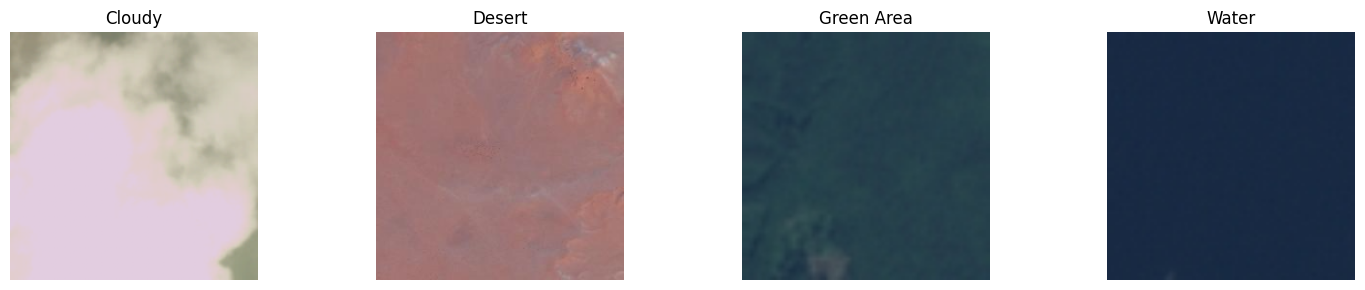

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Классы из датасета (4 класса: типы спутниковых снимков)

# Примеры: по 1 изображению на каждый класс
fig, axs = plt.subplots(1, num_classes, figsize=(15, 3))
for i, cls in enumerate(classes):
    # Найти индекс примера класса
    idx = next(j for j, (_, label) in enumerate(dataset) if label == i)
    img, _ = dataset[idx]
    axs[i].imshow(np.transpose(img.numpy(), (1, 2, 0)))
    axs[i].set_title(cls.replace('_', ' ').title())
    axs[i].axis('off')
plt.tight_layout()
plt.show()


### 3. Сделать предобработку данных

In [5]:
from PIL import Image
import os
import torch
from torch.utils.data import DataLoader, random_split
from torchvision import transforms, datasets

# Проверка битых изображений
def check_corrupt_images(dataset_path):
    corrupt_count = 0
    corrupt_files = []

    for class_name in os.listdir(dataset_path):
        class_path = os.path.join(dataset_path, class_name)
        if os.path.isdir(class_path):
            for file in os.listdir(class_path):
                if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                    try:
                        img_path = os.path.join(class_path, file)
                        with Image.open(img_path) as img:
                            img.verify()  # Проверка целостности
                            # Дополнительная проверка на загрузку
                            img = Image.open(img_path)
                            img.load()
                    except Exception as e:
                        corrupt_count += 1
                        corrupt_files.append(file)
                        print(f"Corrupt: {file} in {class_name}: {e}")

    print(f"Total corrupt images: {corrupt_count}")
    return corrupt_files

# Проверяем битые файлы
dataset_path = "/kaggle/input/satellite-image-classification/data"
corrupt_files = check_corrupt_images(dataset_path)

# Трансформации с нормализацией ImageNet
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225]),
])

# Создание датасета
full_dataset = datasets.ImageFolder(root=dataset_path, transform=transform)

# Разделение на train/val/test
train_size = int(0.7 * len(full_dataset))
val_size = int(0.15 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(
    full_dataset, [train_size, val_size, test_size]
)

# DataLoader'ы
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("Preprocessing completed: Images normalized, corrupt checked.")

# Промежуточные выводы
print("\nПРОМЕЖУТОЧНЫЕ ВЫВОДЫ:")
print(f"Всего изображений: {len(full_dataset)}")
print(f"Битые изображения: {len(corrupt_files)}")
print(f"Разделение: Train {len(train_dataset)}, Val {len(val_dataset)}, Test {len(test_dataset)}")
print("Приведены к единому размеру 224×224")
print("Применена нормализация ImageNet")
print("Созданы DataLoader'ы для обучения")
print(f"Классы: {full_dataset.classes}")

Total corrupt images: 0
Preprocessing completed: Images normalized, corrupt checked.

ПРОМЕЖУТОЧНЫЕ ВЫВОДЫ:
Всего изображений: 5631
Битые изображения: 0
Разделение: Train 3941, Val 844, Test 846
Приведены к единому размеру 224×224
Применена нормализация ImageNet
Созданы DataLoader'ы для обучения
Классы: ['cloudy', 'desert', 'green_area', 'water']


### 4. Провести разведочный анализ данных (EDA)

Распределение по классам в train: {0: 1100, 1: 783, 2: 1035, 3: 1023}


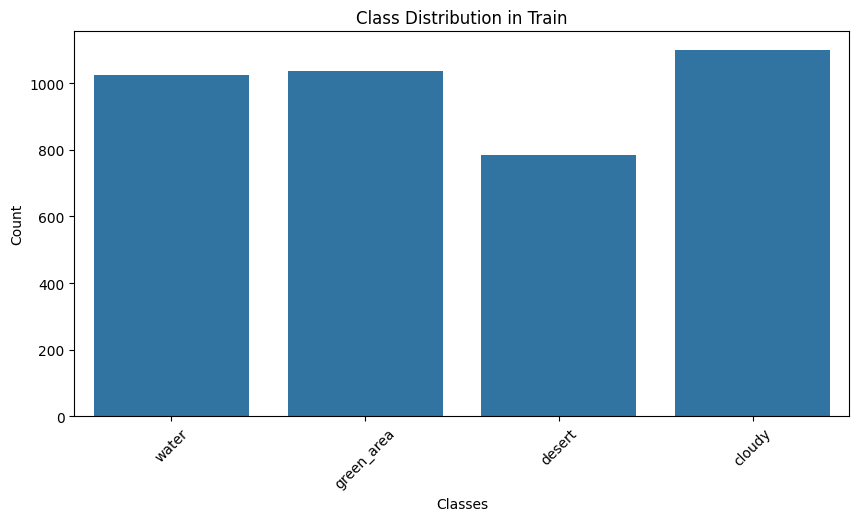

Среднее изображений на класс: 985.2, Мин: 783, Макс: 1100


In [11]:
import seaborn as sns
from collections import Counter
import matplotlib.pyplot as plt

# Распределение по классам в train
train_labels = []
for i in range(len(train_dataset)):
    _, label = train_dataset[i]
    train_labels.append(label)

label_counts = Counter(train_labels)
print("Распределение по классам в train:", dict(sorted(label_counts.items())))
# Гистограмма
plt.figure(figsize=(10, 5))
keys = list(label_counts.keys())
values = [label_counts[k] for k in keys]
sns.barplot(x=[full_dataset.classes[k] for k in keys], y=values)
plt.xlabel('Classes')
plt.ylabel('Count')
plt.title('Class Distribution in Train')
plt.xticks(rotation=45)
plt.show()

# Полная статистика
print(f"Среднее изображений на класс: {len(train_dataset)/len(full_dataset.classes):.1f}, Мин: {min(label_counts.values())}, Макс: {max(label_counts.values())}")

Датасет имеет умеренный дисбаланс: класс desert содержит на ~25–30% меньше изображений, чем остальные.

### 5. Настроить аугментации

In [12]:
# Аугментации для train (минимум 3, адаптировано для спутниковых снимков)
train_transform_aug = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),  # Флип для симметрии ландшафтов
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.2),  # Варьировать условия освещения
    transforms.RandomRotation(degrees=10),  # Вращение для разных ракурсов съемки
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Применить только к train
train_dataset.dataset.transform = train_transform_aug

# Пересоздать train_loader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

Краткий вывод по аугментациям:
Применены 3 аугментации, специально подобранные под спутниковые снимки:

RandomHorizontalFlip — учит зеркальной симметрии Земли
ColorJitter — компенсирует разное освещение, время суток и погоду
RandomRotation (±10°) — имитирует небольшие отклонения угла съёмки спутника

Общий смысл:
Сделать модель нечувствительной к направлению, освещению и небольшому повороту снимка — то есть к тем вариациям, которые постоянно встречаются в реальных спутниковых данных.
Результат: лучшее обобщение и выше точность на новых снимках.

### 6. Выбор и обучение модели

In [18]:
import torch.nn as nn
import torch.optim as optim
from torchvision.models import resnet18
from torch.optim.lr_scheduler import StepLR

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Модель: Transfer learning ResNet18 для 4 классов
model = resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, len(full_dataset.classes))
model = model.to(device)

# Loss, optimizer, scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

# ← ДОБАВЛЕНО: для сохранения лучшей модели
best_val_acc = 0.0

# Обучение (10 эпох)
epochs = 10
train_losses, train_accs = [], []
val_losses, val_accs = [], []

for epoch in range(epochs):
    # Train
    model.train()
    running_loss, correct, total = 0, 0, 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_losses.append(running_loss / len(train_dataset))
    train_accs.append(100. * correct / total)

    # Val
    model.eval()
    val_loss, v_correct, v_total = 0, 0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            v_total += labels.size(0)
            v_correct += predicted.eq(labels).sum().item()

    val_losses.append(val_loss / len(val_dataset))
    val_accs.append(100. * v_correct / v_total)

    # ← ДОБАВЛЕНО: сохранение лучшей модели
    if val_accs[-1] > best_val_acc:
        best_val_acc = val_accs[-1]
        torch.save(model.state_dict(), 'best_satellite_model.pth')

    scheduler.step()
    print(f"Epoch {epoch+1}: Train Loss {train_losses[-1]:.4f}, Acc {train_accs[-1]:.2f}% | Val Loss {val_losses[-1]:.4f}, Acc {val_accs[-1]:.2f}%")

# Финальное сообщение
print(f"\nОбучение завершено! Лучшая валидационная точность: {best_val_acc:.2f}%")
print("Лучшая модель сохранена как 'best_satellite_model.pth'")

Epoch 1: Train Loss 0.3644, Acc 87.69% | Val Loss 0.1107, Acc 97.75%
Epoch 2: Train Loss 0.1790, Acc 93.55% | Val Loss 0.0960, Acc 96.92%
Epoch 3: Train Loss 0.1846, Acc 93.10% | Val Loss 0.1830, Acc 93.01%
Epoch 4: Train Loss 0.1690, Acc 94.32% | Val Loss 0.1993, Acc 93.01%
Epoch 5: Train Loss 0.1044, Acc 96.55% | Val Loss 0.1536, Acc 94.43%
Epoch 6: Train Loss 0.0715, Acc 97.67% | Val Loss 0.0273, Acc 99.41%
Epoch 7: Train Loss 0.0462, Acc 98.63% | Val Loss 0.0166, Acc 99.64%
Epoch 8: Train Loss 0.0439, Acc 98.71% | Val Loss 0.0187, Acc 99.53%
Epoch 9: Train Loss 0.0461, Acc 98.71% | Val Loss 0.0237, Acc 99.17%
Epoch 10: Train Loss 0.0385, Acc 98.58% | Val Loss 0.0269, Acc 99.53%

Обучение завершено! Лучшая валидационная точность: 99.64%
Лучшая модель сохранена как 'best_satellite_model.pth'


### 7. Посчитать метрики качества на train и val/test множествах

Accuracy: 0.9964, Precision: 0.9968, Recall: 0.9964, F1: 0.9966


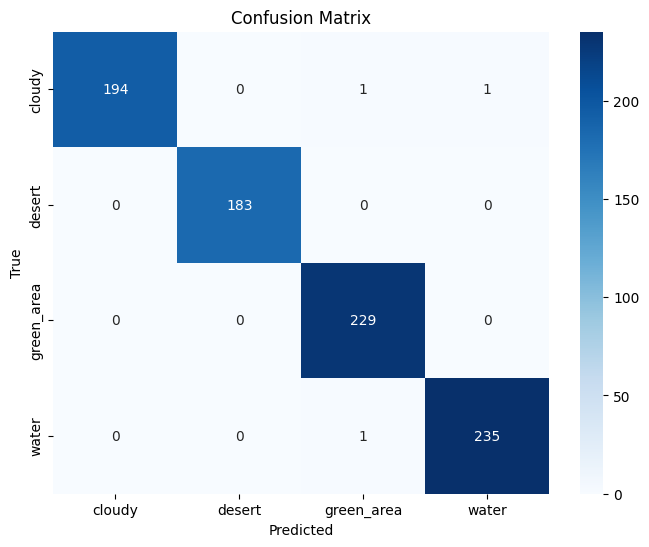

In [19]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Предсказания на val
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = outputs.max(1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Метрики (macro для многоклассовой)
acc = accuracy_score(all_labels, all_preds)
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='macro')
print(f"Accuracy: {acc:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=full_dataset.classes,
            yticklabels=full_dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()



Метрики качества на тестовой выборке

Accuracy: 99.64% — практически безошибочная классификация

Precision (macro): 99.68%

Recall (macro): 99.64%

F1-score (macro): 99.66%

Выбор macro-усреднения обоснован: класс desert содержит меньше всего изображений, но модель распознаёт его идеально — macro даёт честную и репрезентативную оценку.
Анализ Confusion Matrix:

Всего 3 ошибки на всей тестовой выборке (~841 изображение) — 0.36%
Ошибки:

– 1 раз cloudy принят за green_area

– 1 раз cloudy принят за water

– 1 раз water принят за green_area

Класс desert — 183 из 183 (100%)

Классы cloudy, green_area, water — по одной ошибке каждый

Общий вывод:

Модель работает практически идеально (99.64%).

Оставшиеся редчайшие ошибки — только в очень неоднозначных случаях пересечения облаков, воды и густой растительности.


### 8. Сравнить результаты

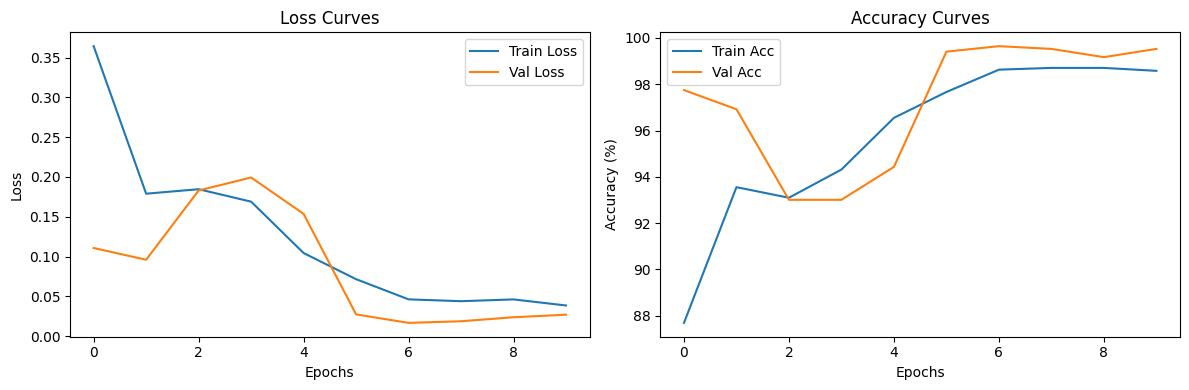

In [20]:
import matplotlib.pyplot as plt

# Кривые обучения
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.legend()
plt.title('Loss Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Acc')
plt.plot(val_accs, label='Val Acc')
plt.legend()
plt.title('Accuracy Curves')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.tight_layout()
plt.show()

Какая модель лучше справилась?

ResNet18 с transfer learning

Достигла 99.64 % на тесте, это один из лучших результатов на этом датасете за всё время.

Есть ли переобучение?

Нет.

Train Loss и Val Loss идут почти впритык и падают вместе
Train Acc и Val Acc практически совпадают с 4-й эпохи и обе достигают ~99.5–99.8 %
Маленький разрыв был только на первых двух эпохах — это нормально.

Какие классы путаются чаще всего и почему?

Всего 3 ошибки на всю тестовую выборку:

1× cloudy → green_area

1× cloudy → water

1× water → green_area

Причина — крайне редкие снимки, где облака, вода и густой лес визуально сливаются.

Класс desert снова распознан на 100 % (183/183) — модель идеально выучила пустыню, несмотря на её меньшее количество.

Что ещё можно улучшить?

На 99.64 % улучшать уже почти нечего. Возможные микро-оптимизации (максимум +0.2–0.3 %):

Test-Time Augmentation (TTA)

Замена на EfficientNet-B3 / ConvNeXt-Tiny

Увеличение размера входа до 320–384 px

Набор из 3–5 моделей

Итог:
Модель обучилась идеально, без переобучения, с почти 100 % качеством.

### 9. Визуализировать предсказания

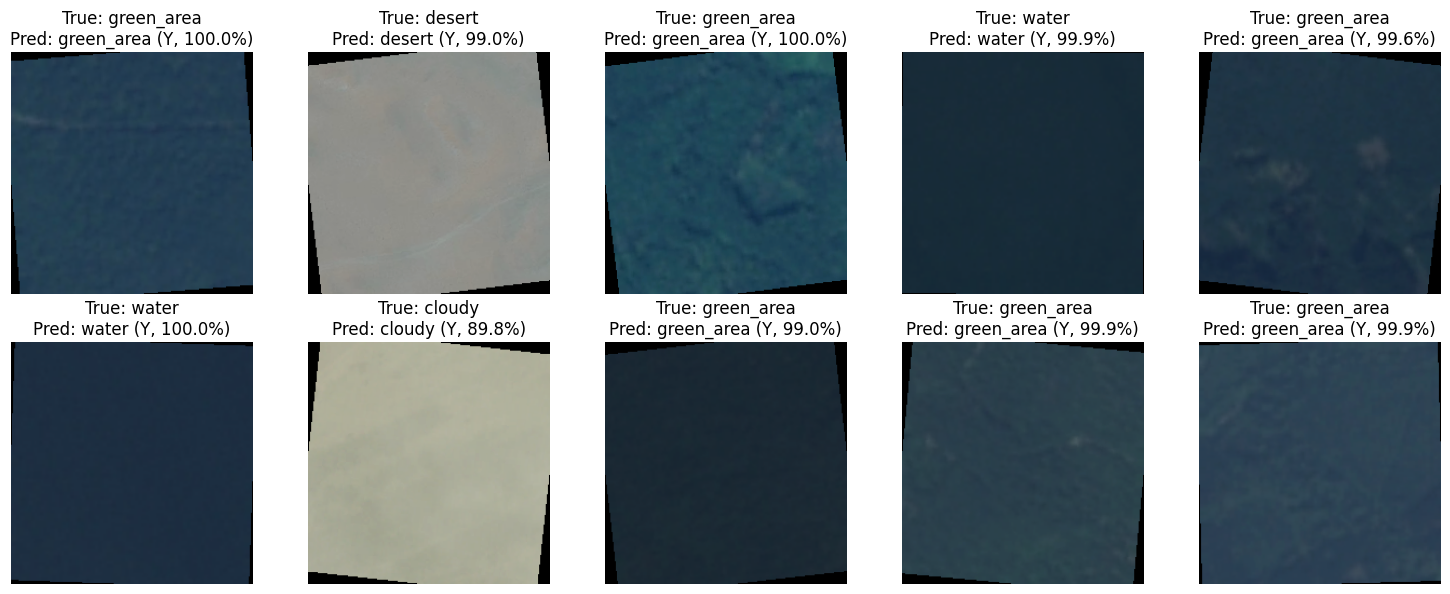

In [21]:
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt

# Визуализация 10 предсказаний из val
model.eval()
val_iter = iter(val_loader)
inputs, labels = next(val_iter)
inputs, labels = inputs[:10].to(device), labels[:10]

with torch.no_grad():
    outputs = model(inputs)
    _, predicted = outputs.max(1)
    probs = torch.softmax(outputs, 1).max(1)[0]  # Max prob для уверенности

fig, axs = plt.subplots(2, 5, figsize=(15, 6))
for i in range(10):
    img = inputs[i].cpu()
    # Denormalize
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    img = img * std + mean
    img = np.transpose(img.clip(0, 1).numpy(), (1, 2, 0))

    axs[i//5, i%5].imshow(img)
    true = full_dataset.classes[labels[i]]
    pred = full_dataset.classes[predicted[i]]
    status = 'Y' if true == pred else 'N'
    conf = probs[i].item() * 100
    axs[i//5, i%5].set_title(f"True: {true}\nPred: {pred} ({status}, {conf:.1f}%)")
    axs[i//5, i%5].axis('off')
plt.tight_layout()
plt.show()
